## 1D CNN Time Series Classification

### Importing Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import RMSprop,adam
from keras.regularizers import l2
from keras.callbacks import History
from keras import callbacks
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_train['failure_lbl_1'] = [1 if i < 50 else 0 for i in df_train.RUL]
    df_train['failure_lbl_2'] = df_train['failure_lbl_1']
    df_train.failure_lbl_2[df_train.RUL < 25] = 2

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    y_true['failure_lbl_1'] = [1 if i < 50 else 0 for i in y_true.RUL]
    y_true['failure_lbl_2'] = y_true['failure_lbl_1']
    y_true.failure_lbl_2[y_true.RUL < 25] = 2
    
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

C:\Users\archd\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


((20631, 20), (13096, 17), (100, 4))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL', 'failure_lbl_1', 'failure_lbl_2'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure_lbl_1,failure_lbl_2
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0,0


In [7]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [8]:
y_true.head()

,RUL,UnitNumber,failure_lbl_1,failure_lbl_2
0,112,0,0,0
1,98,1,0,0
2,69,2,0,0
3,82,3,0,0
4,91,4,0,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [9]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [10]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [11]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

### Function to Print results

In [116]:
def print_results(y_test, y_pred, multi_class = False):
    
    #f1-score
    if multi_class == True:
        f1 = f1_score(y_test, y_pred, average="macro")
    else:
        f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    if multi_class == False:
        model_roc_auc = roc_auc_score(y_test, y_pred) 
        print ("Area under curve : ",model_roc_auc,"\n")
        fpr,tpr,thresholds = roc_curve(y_test, y_pred)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        threshold = np.round(thresholds[ix],3)

        plt.subplot(222)
        plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")

## Binary Classification

In [177]:
sequence_length = 50
mask_value = 0
label = "failure_lbl_1"


Let's prepare data using above functions.

In [178]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [179]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [180]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [181]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [182]:
nb_features = x_train.shape[2]
nb_out = 1

In [183]:
nb_features

15

In [184]:
cls_wt= class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
cls_wt

array([0.7329699, 1.5731   ])

### Model

In [190]:
history = History()

model = Sequential()
model.add(Conv1D(50, 6, activation = 'relu', input_shape=(sequence_length, nb_features)))
model.add(Conv1D(50, 6, activation = 'relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(100, 6, activation = 'relu'))
model.add(Conv1D(100, 6, activation = 'relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_103 (Conv1D)          (None, 45, 50)            4550      
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 40, 50)            15050     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 13, 50)            0         
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 8, 100)            30100     
_________________________________________________________________
conv1d_106 (Conv1D)          (None, 3, 100)            60100     
_________________________________________________________________
global_average_pooling1d_25  (None, 100)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0         
__________

In [191]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                      keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')])

Train on 14157 samples, validate on 1574 samples
Epoch 1/10
14157/14157 [==============================] - 8s 556us/step - loss: 0.2051 - acc: 0.9163 - val_loss: 0.2285 - val_acc: 0.9447
Epoch 2/10
14157/14157 [==============================] - 6s 413us/step - loss: 0.0849 - acc: 0.9688 - val_loss: 0.1779 - val_acc: 0.9365
Epoch 3/10
14157/14157 [==============================] - 6s 410us/step - loss: 0.0476 - acc: 0.9827 - val_loss: 0.2751 - val_acc: 0.9079
Epoch 4/10
14157/14157 [==============================] - 6s 444us/step - loss: 0.0343 - acc: 0.9874 - val_loss: 0.1982 - val_acc: 0.9199
Epoch 5/10
14157/14157 [==============================] - 5s 374us/step - loss: 0.0242 - acc: 0.9894 - val_loss: 0.2789 - val_acc: 0.9238
Wall time: 31.6 s


Text(0.5, 1.0, 'Loss')

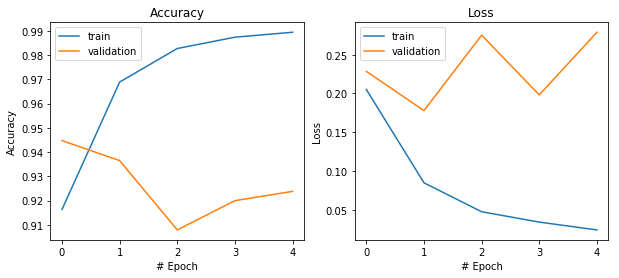

In [192]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

F1 Score:  0.9180327868852459
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        70
           1       0.90      0.93      0.92        30

    accuracy                           0.95       100
   macro avg       0.94      0.95      0.94       100
weighted avg       0.95      0.95      0.95       100

Area under curve :  0.9452380952380953 



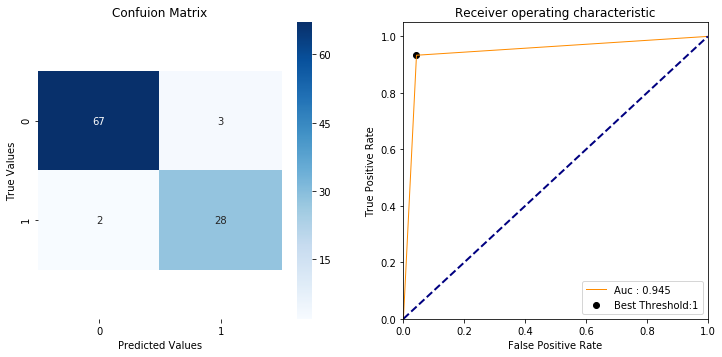

In [193]:
y_pred = model.predict_classes(x_test)

print_results(y_true.failure_lbl_1, y_pred)

In [194]:
confusion_matrix(y_train, model.predict_classes(x_train))

array([[10610,   121],
       [   59,  4941]], dtype=int64)

## Multiclass Classification

In [93]:
sequence_length = 50
mask_value = 0
label = "failure_lbl_2"


Let's prepare data using above functions.

In [94]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [121]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [122]:
y_train2 = to_categorical(y_train)
y_train2

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [96]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [97]:
nb_features = x_train.shape[2]
nb_out = 1

In [98]:
nb_features

15

In [99]:
cls_wt= class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
cls_wt

array([0.4886466 , 2.09746667, 2.09746667])

### Model

In [172]:
history2 = History()

model2 = Sequential()
model2.add(Conv1D(50, 6, activation = 'relu', input_shape=(sequence_length, nb_features)))
model2.add(Conv1D(50, 6, activation = 'relu'))
model2.add(MaxPooling1D(3))
model2.add(Conv1D(100, 6, activation = 'relu'))
model2.add(Conv1D(100, 6, activation = 'relu'))
model2.add(GlobalAveragePooling1D())
model2.add(Dropout(0.5))
model2.add(Dense(units=3, activation='softmax'))

model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_95 (Conv1D)           (None, 45, 50)            4550      
_________________________________________________________________
conv1d_96 (Conv1D)           (None, 40, 50)            15050     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 13, 50)            0         
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 8, 100)            30100     
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 3, 100)            60100     
_________________________________________________________________
global_average_pooling1d_23  (None, 100)               0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
__________

In [173]:
%%time
# fit the model
model2.fit(x_train, y_train2, epochs=10, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history2,
                      keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')])

Train on 14157 samples, validate on 1574 samples
Epoch 1/10
14157/14157 [==============================] - 8s 589us/step - loss: 0.3286 - acc: 0.8674 - val_loss: 0.2224 - val_acc: 0.9028
Epoch 2/10
14157/14157 [==============================] - 6s 400us/step - loss: 0.1774 - acc: 0.9320 - val_loss: 0.2826 - val_acc: 0.8895
Epoch 3/10
14157/14157 [==============================] - 6s 410us/step - loss: 0.1163 - acc: 0.9563 - val_loss: 0.2450 - val_acc: 0.9104
Epoch 4/10
14157/14157 [==============================] - 6s 402us/step - loss: 0.0752 - acc: 0.9715 - val_loss: 0.2898 - val_acc: 0.8964
Wall time: 27.8 s


Text(0.5, 1.0, 'Loss')

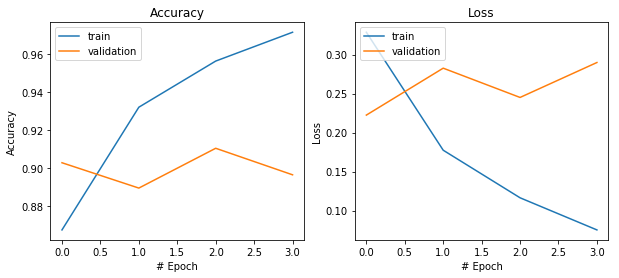

In [174]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history2.history['acc'])
ax[0].plot(history2.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history2.history['loss'])
ax[1].plot(history2.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

F1 Score:  0.8671703160347538
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        70
           1       0.62      0.91      0.74        11
           2       1.00      0.79      0.88        19

    accuracy                           0.93       100
   macro avg       0.87      0.89      0.87       100
weighted avg       0.95      0.93      0.93       100



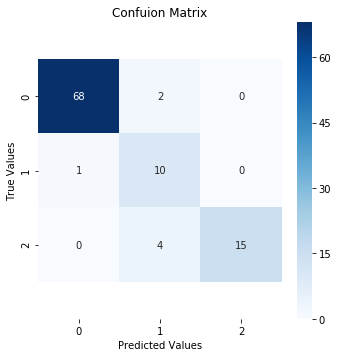

In [175]:
y_pred = model2.predict_classes(x_test)

print_results(y_true.failure_lbl_2, y_pred, multi_class=True)

In [176]:
confusion_matrix(y_train, model2.predict_classes(x_train))

array([[10633,    98,     0],
       [   99,  2384,    17],
       [    0,   277,  2223]], dtype=int64)